# Dimensionality reduction

###### COMP4670/8600 - Introduction to Statistical Machine Learning - Week 6

Setting up the environment

In this lab, we will use dimensionality reduction techniques to explore a dataset of pictures.

### Assumed knowledge
- Neural net implementation (week 5 lab)
- Autoencoders and PCA (week 6 lectures)

### After this lab, you should be comfortable with:
- Implementing PCA
- Implementing an autoencoder
- Visualising features derived from dimensionality reduction


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
%matplotlib inline

## Load the data

For this lab, we will use a dataset of images of Pokemon sprites.

Load the dataset from the file ``06-dataset.csv`` using ``np.loadtxt``. The datafile represents a 2d array where each row is a 64 by 64 pixel greyscale picture. The entries are floats between 0 and 1, where 0 is white and 1 is black.

Note that while the images are 64 by 64 entries, the dataset you load has rows of size 4096 (which is $64\times 64$) to allow the data to be saved as a 2D array.

In [2]:
# Solution
images = np.loadtxt('06-dataset.csv')

## (Optional) Toy dataset for debugging

For debugging, it is useful to also have a simple dataset that we know is one-dimensional with some noise. You can use this to test your functions produce sensible output.

Write a function that generates data from two Gaussians in $\mathbb{R}^n$ with unit variance, centered at $\mathbf{1}$ and $-\mathbf{1}$ respectively. (Note: $\mathbf{1}$ is the vector $(1, 1, 1, ..., 1)$ in $\mathbb{R}^n$.)

Use the function to generate 100 samples from each Gaussian, with $n=5$.

In [3]:
# Solution
def gen_data(n_samples=100, n_feat=5):
    """Generate data from two Gaussians
    n_samples = number of samples from each Gaussian
    n_feat = dimension of the features
    """
    X1 = np.ones((n_feat, n_samples)) + np.random.randn(n_feat, n_samples)
    X2 = -np.ones((n_feat, n_samples)) + np.random.randn(n_feat, n_samples)
    X = np.hstack([X1,X2])
    return X

toy_data = gen_data()


## Implementing PCA

### Recap on PCA

Remember from lectures that the goal of PCA is to linearly project data points onto a lower dimensional subspace such that the variance of the projected data is maximised. 

Let the data be the set of data points $\{\mathbf{x}_n\}_{n=1}^N$, $\mathbf{x}_n\in\mathbb{R}^d$, with mean $\bar{\mathbf{x}}=\frac{1}{N}\sum_{n=1}^N\mathbf{x}_n$ and covariance matrix $\mathbf{S}=\frac{1}{N}\sum_{n=1}^N(\mathbf{x}_n-\bar{\mathbf{x}})(\mathbf{x}_n-\bar{\mathbf{x}})^T.$

From lectures, we derived that if we are linearly projecting onto a subspace $m<d$, then the $m$ directions to linearly project on are given by the $m$ eigenvectors of $\mathbf{S}$ whose eigenvalues are the $m$ largest, and the variance along each direction is equal to that eigenvalue.

### Using the SVD to implement PCA

Let us assume that $\bar{\mathbf{x}}=\mathbf{0}$. Then $\mathbf{S}=\frac{1}{N}\sum_{n=1}^N\mathbf{x}_n\mathbf{x}_n^T$. 
However, it turns out that
$$\sum_{n=1}^N\mathbf{x}_n\mathbf{x}_n^T=X^TX$$
where $X\in\mathbb{R}^{N\times d}$ is the data matrix.
Thus to find the eigenvalues and vectors of the covariance matrix, we need to find the eigenvalues and vectors of $\frac{1}{N}X^TX$.

It turns out that if the SVD of $X$ is $X=U\Sigma V^T$, then the eigenvectors of $\mathbf{S}$ that correspond to its $k$ largest eigenvalues are the column vectors of $V$ that correspond to the $k$ largest singular values of $X$. **Sorry this was wrong in the previous version, where it had $U$ instead of $V$**.

### Question
Show the left out steps (the two parts where it says "it turns out").

### Solution

To show the first part, using the notation for representing a $dxd$ matrix from its entries by $A=\big[A_{ij}\big]_{i=1, j=1}^{d, d}$ and the $i^{th}$ row of $A$ by $A_{i,\cdot}$, we have that
$$
\begin{align*}
    \sum_{n=1}^N\mathbf{x}_n\mathbf{x}_n^T
        &= \Bigg[\sum_{n=1}^N\left(\mathbf{x}_n\right)_i\left(\mathbf{x}_n^T\right)_j\Bigg]_{i=1, j=1}^{d, d}\\
        &= \Bigg[X_{\cdot, i}\cdot X_{\cdot, j}\Bigg]_{i=1, j=1}^{d, d}\\
        &= X^TX.
\end{align*}
$$

To show the second part, let the SVD of $X$ be $X=U\Sigma V^T$. Then we have that
\begin{align*}
    \mathbf{S}
        &= \frac{1}{N}X^TX\\
        &= \frac{1}{N}(U\Sigma V^T)^TU\Sigma V^T\\
        &= \frac{1}{N}V\Sigma^TU^TU\Sigma V^T\\
        &= \frac{1}{N}V\Sigma^2V^T\\
        &= V\left(\frac{1}{N}\Sigma^2\right)V^T
\end{align*}
(note that $U$ and $V$ are orthogonal) so $\mathbf{S}$ is diagonalised by $V$ and has eigenvalues given by the diagonal matrix $\frac{1}{N}\Sigma^2$.

We call these eigenvectors the principal directions, and rank their importance based on the size of their respective eigenvalues (which can also be done by the size of the singular values of $X$ as squaring is monotonic). A nice property of the SVD function in numpy is that the singular values are already sorted in descending order.

To get the principal components, which is the data's projection on the principal directions, we just need to compute $XV$ (take only the first k columns of $V$ if you want it on the $k$ princpal directions). However as $X=U\Sigma V^T$ and $V$ is orthogonal, $XV=U\Sigma$. Thus the $k$ principal components of $X$ is the first $k$ columns of $U\Sigma$.

### Implement PCA
Implement principal component analysis. Your function should take the data matrix and the number of components you wish to calculate and return two matrices:
1. The projection of the data onto the principal components
2. The actual components (eigenvectors) themselves.

Hint: Do not forget to center the data by removing the mean so that you can use the above method. You may find ``np.linalg.svd`` useful.

In [4]:
# Solution
def pca(X, n_pc=2):
    """Returns the projection onto the principal components (default=2)"""
    X = X.copy()
    n_samples, n_features = X.shape
    M = np.mean(X, axis=0)
    X -= M
    U, S, V = np.linalg.svd(X)
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    
    return projected, components, U, S, V

def svd2pca(U,S,V, n_pc=2):
    """Returns the projection onto the principal components (default=2). Used for
    when you want to change n_pc and have already computed the SVD once"""
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc] 
    return projected, components, S

### (Optional) Verifying the calculation with the toy data

Calculate the projection of the toy data onto the first two principal components. Plot the results, with the datapoints coloured according to which Gaussian they were drawn from.

1. Does PCA pick up the two Gaussians?
- What are the eigenvalues associated to these principal components? What do they tell you about how much variance these components explain?

(5, 200)
[35.63249209 15.18795254 14.98214221 13.22587684 12.46692629]


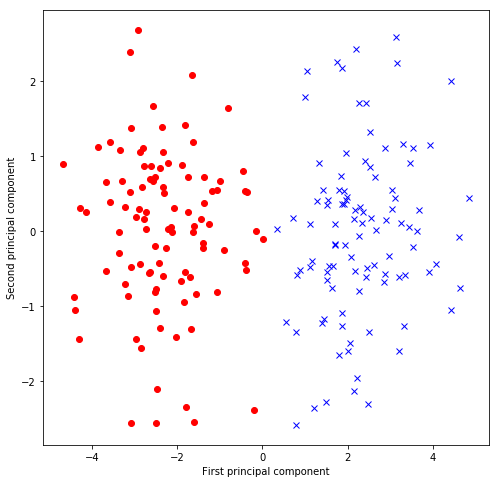

In [5]:
# Solution
print(toy_data.shape)
Z, P, U, S, V = pca(toy_data.T)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(Z[:100,0], Z[:100,1], 'ro')
ax.plot(Z[100:,0], Z[100:,1], 'bx')
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
print(S)

## Eigen-pokemon

If we perform PCA on a dataset, we expect the principal components to lie in the neighbourhood of our datapoints. In particular, if we do this on a dataset of images, we can interpret the principal components as images.

The following function plots a gallery of images.

In [6]:
# Visualising images
def plot_gallery(images, titles, h, w, n_row=2, n_col=6):
    """Helper function to plot a gallery of portraits.
    Arguments: images: a matrix where each row is an image.
    titles: an array of labels for each image.
    h: the height in pixels of each image.
    w: the width in pixels of each image.
    n_row: the number of rows of images to print.
    n_col: the number of columns of images to print."""
    assert len(images) >= n_row * n_col
    assert len(titles) >= n_row * n_col
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    plt.show()

Use ``plot_gallery`` to plot the first 30 pokemon images.

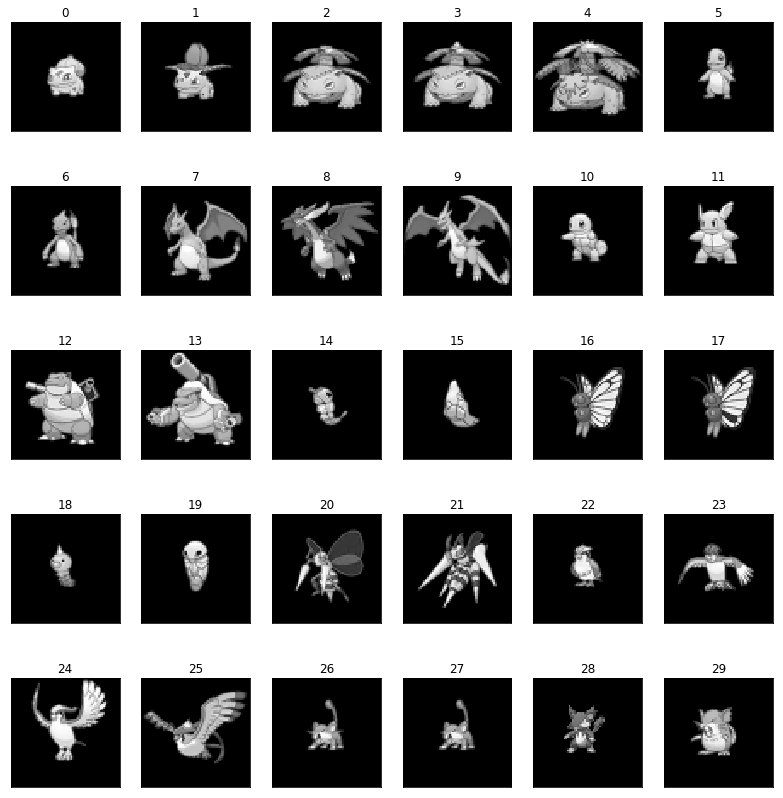

In [7]:
# Solution

plot_gallery(images, np.arange(30), 64, 64, 5, 6)

Perform PCA on the Pokemon dataset to find the first 200 principal components. Visualise the first 100 using ``plot_gallery``.

### Question

What do you notice about the first few principal components? What are they detecting?
Plot the associated eigenvalues. How can you interpret these?

In [8]:
# Solution

h = 64
w = 64
n_components = 200
Z, P, U, S, V = pca(images, n_pc=n_components)
eigenmon = P.reshape((n_components, h, w))
eigenmon_titles = ["eigenmon %d" % i for i in range(eigenmon.shape[0])]
plot_gallery(eigenmon, eigenmon_titles, h, w, n_components//10, 10)

### Solution:
The first few principal components are capturing large scale features, specifically the size, wings, head, feet and orientation to some degree.

The eigenvalues indicate the variance along the direction of the related eigenvector, and thus can be interpreted as a measure of importance when trying to reconstruct the diverse Pokemon. Note how the eigenvalues of $\mathbf{C}$ and singular values of $X$ are related from the derivation, specifically we have that $\lambda_i=\frac{1}{N}(\Sigma_{i,i})^2$.

From plotting, we can see that first few components/eigenvectors are very important, and the first 200 are relatively important in capturing variance. We can see the latter when comparing between the reconstructions using 15 and 200 components in the next question.

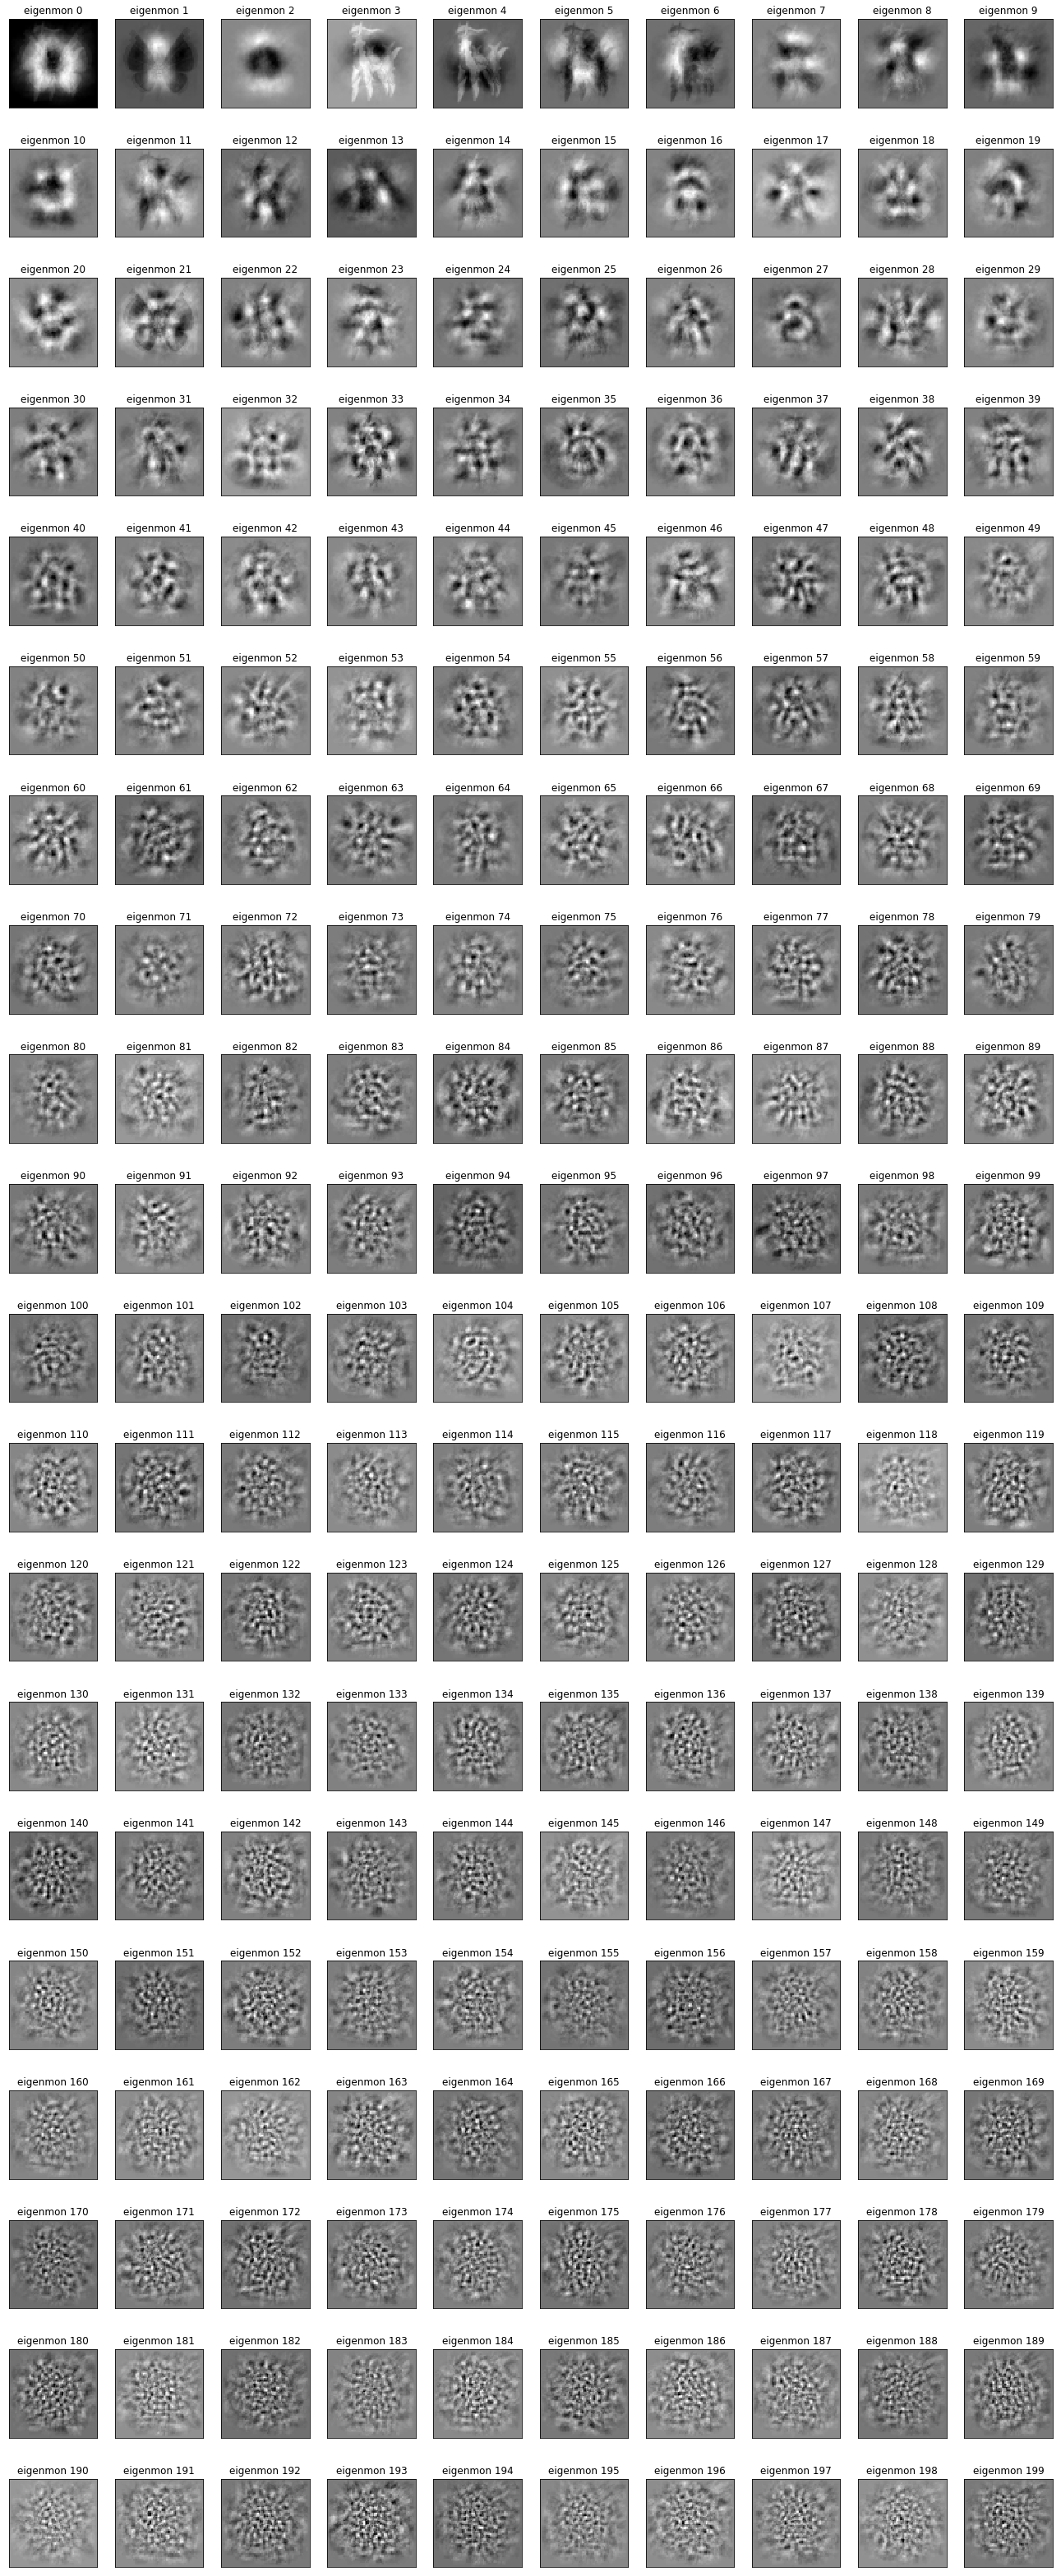

Text(0, 0.5, 'Eigenvalue')

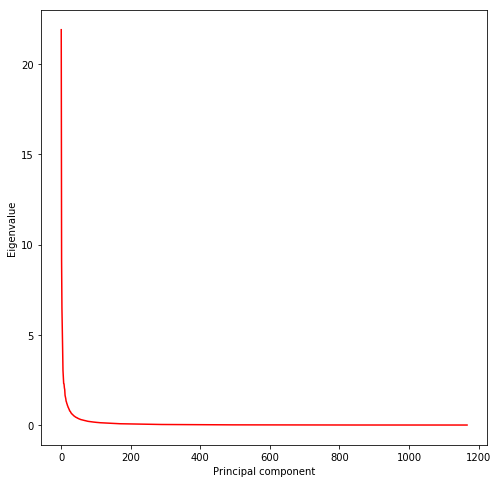

In [9]:
# Solution

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(np.arange(S.shape[0]), 1/(images.shape[0])*(S**2), 'r-')
ax.set_xlabel('Principal component')
ax.set_ylabel('Eigenvalue')

## Reconstructing images using PCA

Plot the reconstructions of the first 30 images using 200 principal components, and using the first 15 principal components. Don't forget to add the mean back in. How good are these reconstructions?

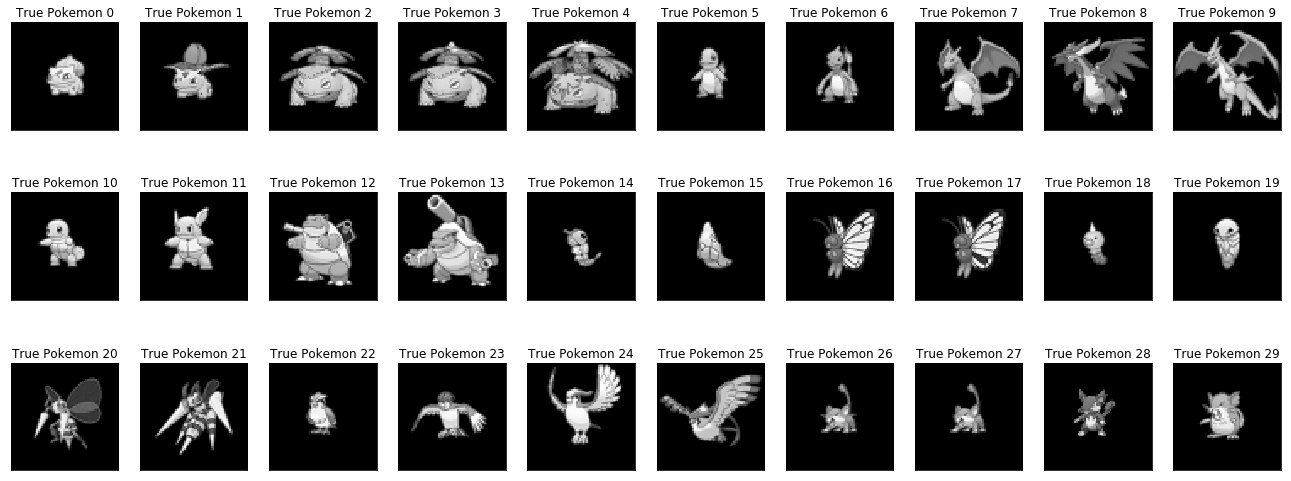

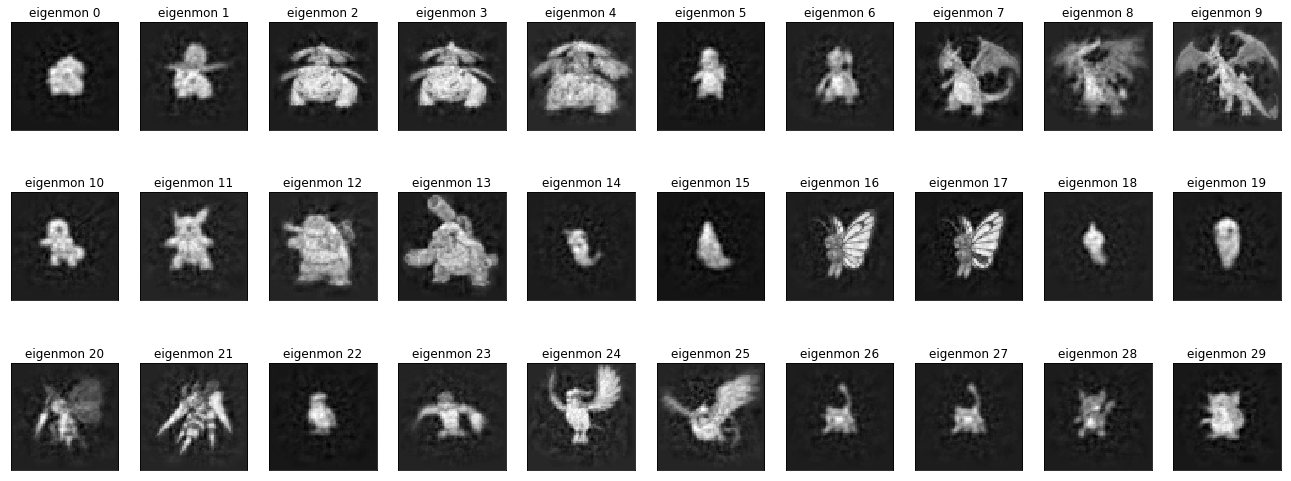

In [10]:
# Solution
M = np.mean(images, axis=0)

plot_gallery(images, ['True Pokemon {:d}'.format(i) for i in range(30)], h, w, 3, 10)

Z, P, S = svd2pca(U, S, V, n_pc=200)
plot_gallery(np.dot(Z, P)+M, eigenmon_titles, h, w, 3, 10)

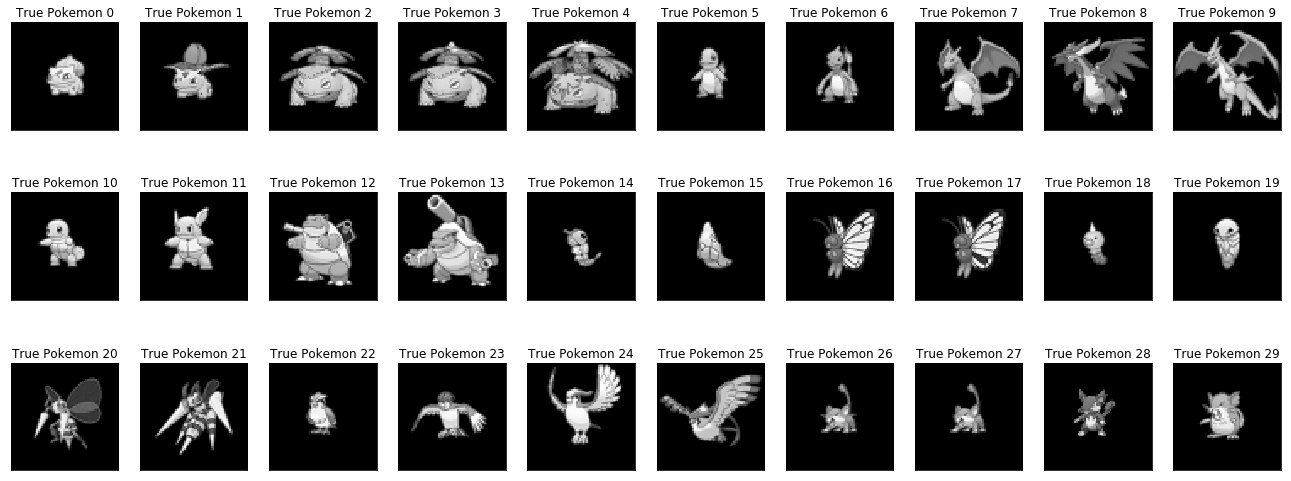

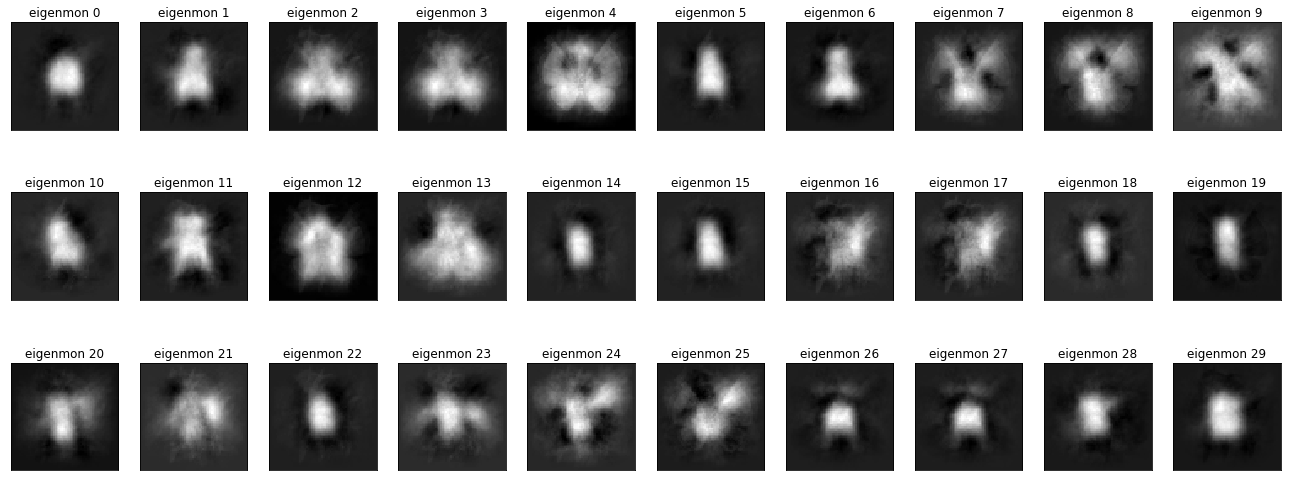

In [11]:
# Solution
M = np.mean(images, axis=0)
plot_gallery(images, ['True Pokemon {:d}'.format(i) for i in range(30)], h, w, 3, 10)

Z, P, S = svd2pca(U, S, V, n_pc=15)
plot_gallery(np.dot(Z, P)+M, eigenmon_titles, h, w, 3, 10)

## Dimensionality Reduction with Autoencoders

Another method of dimensionality reduction is by using an autoencoder. We will be implementing a **stacked undercomplete autoencoder**. We will be working off the neural network implementation from last week, but will make some changes.

We are also going to try to get a much better result than PCA, in particular try to encode the Pokemon into **a subspace of dimension 4**. This means that the bottleneck hidden layer, or *code*, is of length 4. In order to get such good results, we are going to have to use some of the tricks from the lectures, in particular **Xavier Initialisation**, **ReLU activations** and **Mini-batch training**.

We are going to make two explicit network classes, an encoder and a decoder. Each will have 3 fully connected layers, we will be going from 4096 to 512 to 64 and then 4, and vice-versa for the decoder.

The first part we will implement is the FullyConnectedLayer(). The only part we are going to change is the initialisation method, from normally distributed weights with standard deviation 1 to using **Xavier initialisation**. As explained in lectures, this is to help saturation (see follow up question below). In lectures, the standard deviation deviation for Xavier initialisation of normally distributed weights is 
$$\sqrt{\frac{1}{n_{in}}}$$
but we are going to change this to the more commonly used variant (considers making sure the backpropagated signal is also not saturated, see [here](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) for details)

$$\sqrt{\frac{2}{n_{in}+n_{out}}}.$$

Here we have denoted $n_{in}$ as the dimension of the input to the layer, and $n_{out}$ the dimension of the output of the layer.

We will also consider the bias as another input, and thus use the same initialisation (with $n_{in}$ increased by 1).

### Question
What is saturation, and why is it especially important in this network compared to the one we implemented last week?

### Solution

Saturation is when the weights are too large so that bounded activations (e.g. Sigmoid and Tanh) give very small gradient values (see the Sigmoid/Tanh curves and check the gradient at the far ends). As a result, the backpropagated gradients become smaller and smaller . Intuitively, the problem can be considered as "a change in the weights won't affect the cost very much, so finding a local minima is very difficult".

This is especially important in this network due to the fact that we are working with huge layers. While a standard deviation of 1 with the 7 inputs means that the inputs of the next hidden layer are unlikely to be higher than 7 (which is already a low gradient signal for Sigmoid), consider the case now that we have 4096 inputs.


In [12]:
class FullyConnectedLayer():
    """
    This is a class skeleton provided.
    It should perform y = Xw + b and its correspongding gradient.
    If you never defined any classes in python before, you probably want to read other tutorials.
    """
    def __init__(self, in_features, out_features):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        What each represents will be explained in the next few functions.
        """
        self.in_features = in_features
        self.out_features = out_features
        self.weight = np.zeros((in_features, out_features))
        self.bias = np.zeros((out_features, 1))
        self.g_weight = np.zeros((in_features, out_features))
        self.g_bias = np.zeros((out_features, 1))
        self.input = None

    def init_weights(self):
        """
        Currently, the weight and bias of this layer is initilized to zero, which is terrible.
        You want to re-initilize the weight and bias with Xavier initialisation as explained above.
        After you finish, comment out raise NotImplementedError.
        No return value is needed.
        """
        ###############
        #YOU CODE HERE#
        ###############

        raise NotImplementedError

    def forward_pass(self, X):
        """
        Take the output of last layer as X and return the result.
        Don't forget to save the input X to self.input. You will need the input for gradient calculation.
        After you finish, comment out raise NotImplementedError.
        If you are new to python/numpy, you probably want to figure out what is broadcasting 
        (see http://cs231n.github.io/python-numpy-tutorial/#numpy-broadcasting).
        """

        
        self.input = X
        
        out = np.dot(X, self.weight) + self.bias.T
      
        return out
        

    def backward_pass(self, g_next_layer):
        """
        g_next_layer is the gradient passed from next layer (the layer after current layer in forward pass).
        You need to calculate 3 things.
        First, the gradient with respect to bias, self.g_bias.
        Second, the gradient with respect to weights, self.g_weight.
        Third, the gradient with respect to last layer (the layer formed by the current weight and bias), g_last_layer.
        Save the gradient with respect to bias and the gradient with respect to weight.
        Return the gradient with respect to last layer.
        """

        self.g_weight = np.dot(self.input.T, g_next_layer)
        self.g_bias = np.sum(g_next_layer, axis=0, keepdims=True)

        g_last_layer = np.dot(g_next_layer, self.weight.T)

        return g_last_layer

    def update(self, learning_rate):
        """
        Update the weight and bias use the gradient that you just calculated.
        No return is needed.
        """
        
        self.weight -= learning_rate*self.g_weight
        self.bias -= learning_rate*self.g_bias.T


In [13]:
# Solution

class FullyConnectedLayer():
    """
    This is a class skeleton provided.
    It should perform y = Xw + b and its correspongding gradient.
    If you never defined any classes in python before, you probably want to read other tutorials.
    """
    def __init__(self, in_features, out_features):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        What each represents will be explained in the next few functions.
        """
        self.in_features = in_features
        self.out_features = out_features
        self.weight = np.zeros((in_features, out_features))
        self.bias = np.zeros((out_features, 1))
        self.g_weight = np.zeros((in_features, out_features))
        self.g_bias = np.zeros((out_features, 1))
        self.input = None

    def init_weights(self):
        """
        Currently, the weight and bias of this layer is initilized to zero, which is terrible.
        You want to re-initilize the weight and bias with Xavier initialisation as explained above.
        After you finish, comment out raise NotImplementedError.
        No return value is needed.
        """
        std_dev = np.sqrt(2. / (self.in_features + self.out_features + 1))
        self.weight = np.random.normal(0, std_dev, (self.in_features, self.out_features))
        self.bias = np.random.normal(0, std_dev, (self.out_features, 1))

    def forward_pass(self, X):
        """
        Take the output of last layer as X and return the result.
        Don't forget to save the input X to self.input. You will need the input for gradient calculation.
        After you finish, comment out raise NotImplementedError.
        If you are new to python/numpy, you probably want to figure out what is broadcasting 
        (see http://cs231n.github.io/python-numpy-tutorial/#numpy-broadcasting).
        """

        
        self.input = X
        
        out = np.dot(X, self.weight) + self.bias.T
      
        return out
        

    def backward_pass(self, g_next_layer):
        """
        g_next_layer is the gradient passed from next layer (the layer after current layer in forward pass).
        You need to calculate 3 things.
        First, the gradient with respect to bias, self.g_bias.
        Second, the gradient with respect to weights, self.g_weight.
        Third, the gradient with respect to last layer (the layer formed by the current weight and bias), g_last_layer.
        Save the gradient with respect to bias and the gradient with respect to weight.
        Return the gradient with respect to last layer.
        """

        self.g_weight = np.dot(self.input.T, g_next_layer)
        self.g_bias = np.sum(g_next_layer, axis=0, keepdims=True)

        g_last_layer = np.dot(g_next_layer, self.weight.T)

        return g_last_layer

    def update(self, learning_rate):
        """
        Update the weight and bias use the gradient that you just calculated.
        No return is needed.
        """
        
        self.weight -= learning_rate*self.g_weight
        self.bias -= learning_rate*self.g_bias.T


Next we are going to implement our activation functions. We already have our Sigmoid layer from last week. We need to use this at the end of our network, as our outputs (the resulting image) needs to be within $[0,1]$. However, for the inner activation functions, we are going to use the **ReLU** function which works better in practice.

### Question
What is the benefit of ReLU as an activation function? What is its gradient?

### Solution

The ReLU function is defined as $h(x)=\max(0,x)$ and has gradient
$$h'(x)=\begin{cases}
    0 & x \leq 0\\
    1 & x > 0\\
    \end{cases}$$

ReLU does not suffer from exploding/vanishing gradient problems as much as it has a gradient of 1 on its support, and yet is non-linear due to the cut-off at 0. Its cut-off also promotes sparsity.

In [14]:
def sigmoid(X):
    """
    Make sure that you function works with X being matrix.
    Use functions in numpy instead of functions in math.
    """
    return 1/(1 + np.exp(-X))
class Sigmoid():
    def __init__(self):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        """
        self.input = None

    def forward_pass(self, X):
        """
        Apply sigmoid function to input and save the input for later.
        """
        
        self.input = X

        return sigmoid(X)

    def backward_pass(self, g_next_layer):
        """
        Calculate the gradient with respect to the input.
        g_next_layer is the gradient passed from next layer (the layer after current layer in forward pass).
        Return the gradient with respect to the output of the last layer.
        """
        g_last_layer = sigmoid(self.input) * ( 1 - sigmoid(self.input)) * g_next_layer

        return g_last_layer

    def update(self, learning_rate):
        """
        There is no parameter to update for this layer, but we still define this function to maintain a uniform interface.
        """
        pass


class ReLU():
    def __init__(self):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        """
        self.input = None

    def forward_pass(self, X):
        """
        Apply sigmoid function to input and save the input for later.
        """
        
        self.input = X

        ###############
        #YOU CODE HERE#
        ###############
        
        raise NotImplementedError

        return None

    def backward_pass(self, g_next_layer):
        """
        Calculate the gradient with respect to the input.
        g_next_layer is the gradient passed from next layer (the layer after current layer in forward pass).
        Return the gradient with respect to the output of the last layer.
        """
        ###############
        #YOU CODE HERE#
        ###############
        
        raise NotImplementedError
        
        g_last_layer = None

        return g_last_layer

    def update(self, learning_rate):
        """
        There is no parameter to update for this layer, but we still define this function to maintain a uniform interface.
        """
        pass

In [15]:
# Solution

def sigmoid(X):
    """
    Make sure that you function works with X being matrix.
    Use functions in numpy instead of functions in math.
    """
    return 1/(1 + np.exp(-X))
class Sigmoid():
    def __init__(self):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        """
        self.input = None

    def forward_pass(self, X):
        """
        Apply sigmoid function to input and save the input for later.
        """
        
        self.input = X

        return sigmoid(X)

    def backward_pass(self, g_next_layer):
        """
        Calculate the gradient with respect to the input.
        g_next_layer is the gradient passed from next layer (the layer after current layer in forward pass).
        Return the gradient with respect to the output of the last layer.
        """
        g_last_layer = sigmoid(self.input) * ( 1 - sigmoid(self.input)) * g_next_layer

        return g_last_layer

    def update(self, learning_rate):
        """
        There is no parameter to update for this layer, but we still define this function to maintain a uniform interface.
        """
        pass


class ReLU():
    def __init__(self):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        """
        self.input = None

    def forward_pass(self, X):
        """
        Apply sigmoid function to input and save the input for later.
        """
        
        self.input = X

        return np.maximum(X, 0)

    def backward_pass(self, g_next_layer):
        """
        Calculate the gradient with respect to the input.
        g_next_layer is the gradient passed from next layer (the layer after current layer in forward pass).
        Return the gradient with respect to the output of the last layer.
        """
        g_last_layer = np.array(self.input>0, dtype=np.float32) * g_next_layer

        return g_last_layer

    def update(self, learning_rate):
        """
        There is no parameter to update for this layer, but we still define this function to maintain a uniform interface.
        """
        pass

We are also going to change our loss function, as we care about the actual values of the resulting sigmoid output, we are not thresholding anything to classify into classes. Thus we are going to use the Mean Squared Error loss (MSE).

In [16]:
class MSELoss():
    def __init__(self):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        """
        self.input_y = None
        self.input_t = None
        self.input_N = None


    def forward_pass(self, y, t):
        """
        y: batch_size * 1  0 <= y <= 1, the predictions
        t: batch_size * 1 , the targets
        (make sure y and t have the same shape. (N,) and (N,1) are different!)
        
        Save the input y, t and batch size N and calculate the loss.
        Return the mean of the loss (a scalar).
        """
        
        ###############
        #YOU CODE HERE#
        ###############
        
        raise NotImplementedError

        return None
    
    def backward_pass(self, g_next_layer = 1):
        """
        Nomrally, loss layer is the last layer in a neural network. Thus, we set the g_next_layer to 1.
        Calculate the loss of the input y.
        """
        raise NotImplementedError
        
        g_last_layer = None

        return g_last_layer

    def update(self, learning_rate):
        """
        There is no parameter to update for this layer, but we still define this function to maintain a uniform interface.
        """
        pass

In [17]:
# Solution

class MSELoss():
    def __init__(self):
        """
        This is the init function where you have all the attributes needed defined.
        You don't have to modify any thing in this function but you should read it carefully.
        """
        self.input_y = None
        self.input_t = None
        self.input_N = None


    def forward_pass(self, y, t):
        """
        y: batch_size * 1  0 <= y <= 1, the predictions
        t: batch_size * 1 , the targets
        (make sure y and t have the same shape. (N,) and (N,1) are different!)
        
        Save the input y, t and batch size N and calculate the loss.
        Return the mean of the loss (a scalar).
        """
        
        if len(t.shape) == 1:
            t = t[:, None]

        self.input_y = y
        self.input_t = t
        self.input_N = X.shape[0]

        loss = (t-y)**2

        return np.mean(loss)
    
    def backward_pass(self, g_next_layer = 1):
        """
        Nomrally, loss layer is the last layer in a neural network. Thus, we set the g_next_layer to 1.
        Calculate the loss of the input y.
        """
        g_last_layer = -2*(self.input_t - self.input_y)/self.input_N * g_next_layer

        return g_last_layer

    def update(self, learning_rate):
        """
        There is no parameter to update for this layer, but we still define this function to maintain a uniform interface.
        """
        pass

Finally we are going to implement the two neural networks, encoder and decoder. To do this, we will extend the Network class, and then just add what we need to ```self.sequential```. Note that we have also added a return value in the backward pass, as we want to pass the gradient from the decoder to the encoder.

The **encoder** should have 3 fully connected layers, going from 4096 to 512 to 64 and then to 4. The activation functions should all be ReLU.

The **decoder** should have 3 fully connected layers, going from 4 to 64 to 512 and then to 4096. The activation functions should all be ReLU, except for the last layer's activation which should be Sigmoid to get the correct range.

If you have time, experiment with changing these. Does changing to Sigmoid reduce performance? Can you get better performance by changing the number of layers and hidden unit sizes?

In [18]:
class Network():
    def __init__(self):
        self.sequential = []
        
    def forward_pass(self, X):

        for l in self.sequential:

            X = l.forward_pass(X)

        return X

    def backward_pass(self, grad):
        
        for l in reversed(self.sequential):

            grad = l.backward_pass(grad)
        
        return grad
            

    def update(self, learning_rate):

        for l in self.sequential:

            l.update(learning_rate)

class Encoder(Network):
    def __init__(self):
        Network.__init__(self)
        """
        Initialize all layers that you need and append them to the list in the correct order.
        Don't forget to initilize the weights for fully connected layers.
        """
        
        ###############
        #YOU CODE HERE#
        ###############
        
        raise NotImplementedError


class Decoder(Network):
    def __init__(self):
        Network.__init__(self)
        """
        Initialize all layers that you need and append them to the list in the correct order.
        Don't forget to initilize the weights for fully connected layers.
        """
        
        ###############
        #YOU CODE HERE#
        ###############
        
        raise NotImplementedError

In [19]:
# Solution

class Network():
    def __init__(self):
        self.sequential = []
        
    def forward_pass(self, X):

        for l in self.sequential:

            X = l.forward_pass(X)

        return X

    def backward_pass(self, grad):
        
        for l in reversed(self.sequential):

            grad = l.backward_pass(grad)
        
        return grad
            

    def update(self, learning_rate):

        for l in self.sequential:

            l.update(learning_rate)

class Encoder(Network):
    def __init__(self):
        Network.__init__(self)
        """
        Initialize all layers that you need and append them to the list in the correct order.
        Don't forget to initilize the weights for fully connected layers.
        """
        
        fc1 = FullyConnectedLayer(4096, 512)
        fc1.init_weights()
        self.sequential.append(fc1)

        relu1 = ReLU()
        self.sequential.append(relu1)

        fc2 = FullyConnectedLayer(512, 64)
        fc2.init_weights()
        self.sequential.append(fc2)

        relu2 = ReLU()
        self.sequential.append(relu2)
        
        fc3 = FullyConnectedLayer(64, 4)
        fc3.init_weights()
        self.sequential.append(fc3)

        relu3 = ReLU()
        self.sequential.append(relu3)


class Decoder(Network):
    def __init__(self):
        Network.__init__(self)
        """
        Initialize all layers that you need and append them to the list in the correct order.
        Don't forget to initilize the weights for fully connected layers.
        """
        
        fc1 = FullyConnectedLayer(4, 64)
        fc1.init_weights()
        self.sequential.append(fc1)

        relu1 = ReLU()
        self.sequential.append(relu1)

        fc2 = FullyConnectedLayer(64, 512)
        fc2.init_weights()
        self.sequential.append(fc2)

        relu2 = ReLU()
        self.sequential.append(relu2)
        
        fc3 = FullyConnectedLayer(512, 4096)
        fc3.init_weights()
        self.sequential.append(fc3)

        sigmoid3 = Sigmoid()
        self.sequential.append(sigmoid3)

We now initialise the classes.

In [20]:
try:
    np.random.seed(1)
    encoder = Encoder()
    decoder = Decoder()
    mse = MSELoss()
    implemented = True
except NotImplementedError:
    implemented = False
    print('you need to complete the implementation')

### Training the neural network
As we are doing dimensionality reduction, there is no need for a train-test split. We have set some hyper-parameters for you, e.g. epochs, batch_size and learning rate. In particular the batch size is much smaller than the training set size.
### Question
What is the benefit of mini-batch training (training with small batch size, not the whole training set)?

### Solution
When you use the whole dataset, you are computing the gradient over a huge number of training examples, some of which will have varying/contradicting directions leading to small steps or a saddle point. Using mini-batches lead to noisy steps that can often get past saddle points and have larger steps. However it is common to use a batch size more than 1 to ensure that the steps are not very noisy, but rather are in somewhat the same direction as the gradient update for the full training set.

There are various ways to improve upon converging faster and overcoming saddle-points/bas local minima like momentum and decay rates.

Epoch 1: Train_loss 0.000000
Epoch 2: Train_loss 0.000000
Epoch 3: Train_loss 0.000000
Epoch 4: Train_loss 0.000000
Epoch 5: Train_loss 0.000000
Epoch 6: Train_loss 0.000000
Epoch 7: Train_loss 0.000000
Epoch 8: Train_loss 0.000000


Epoch 9: Train_loss 0.000000
Epoch 10: Train_loss 0.000000


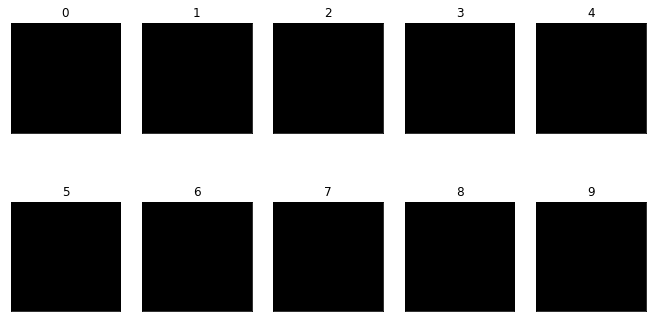

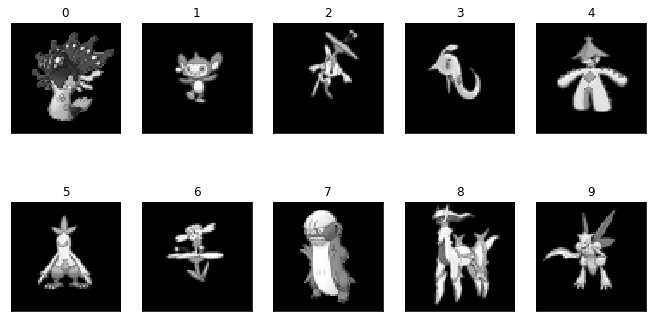

Epoch 11: Train_loss 0.000000
Epoch 12: Train_loss 0.000000
Epoch 13: Train_loss 0.000000
Epoch 14: Train_loss 0.000000
Epoch 15: Train_loss 0.000000
Epoch 16: Train_loss 0.000000
Epoch 17: Train_loss 0.000000
Epoch 18: Train_loss 0.000000
Epoch 19: Train_loss 0.000000
Epoch 20: Train_loss 0.000000


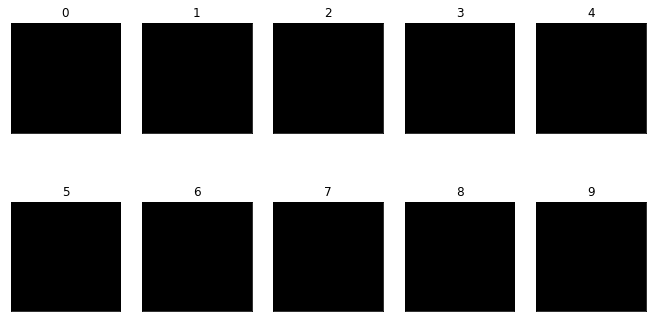

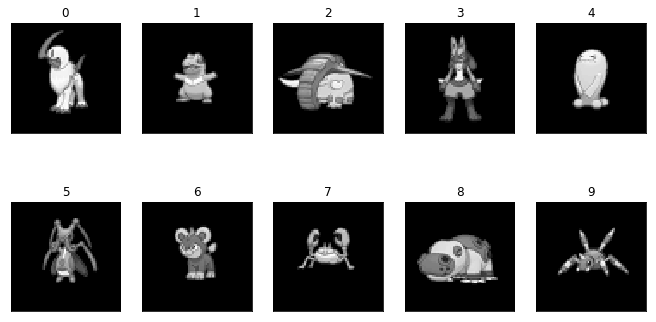

Epoch 21: Train_loss 0.000000
Epoch 22: Train_loss 0.000000
Epoch 23: Train_loss 0.000000
Epoch 24: Train_loss 0.000000
Epoch 25: Train_loss 0.000000
Epoch 26: Train_loss 0.000000
Epoch 27: Train_loss 0.000000
Epoch 28: Train_loss 0.000000
Epoch 29: Train_loss 0.000000
Epoch 30: Train_loss 0.000000


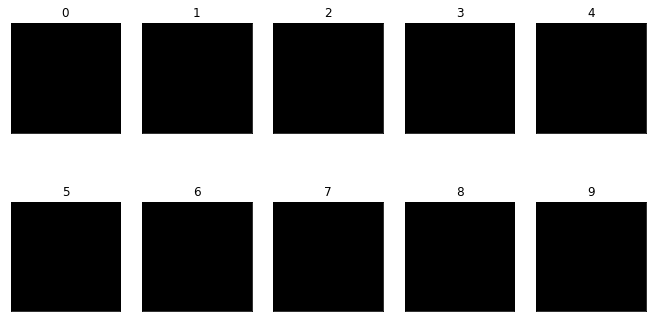

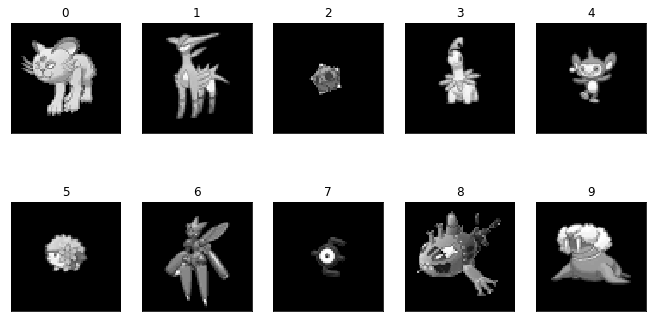

Epoch 31: Train_loss 0.000000
Epoch 32: Train_loss 0.000000
Epoch 33: Train_loss 0.000000
Epoch 34: Train_loss 0.000000
Epoch 35: Train_loss 0.000000
Epoch 36: Train_loss 0.000000
Epoch 37: Train_loss 0.000000
Epoch 38: Train_loss 0.000000
Epoch 39: Train_loss 0.000000
Epoch 40: Train_loss 0.000000


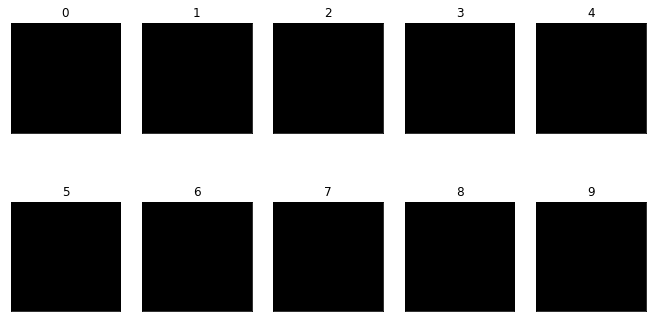

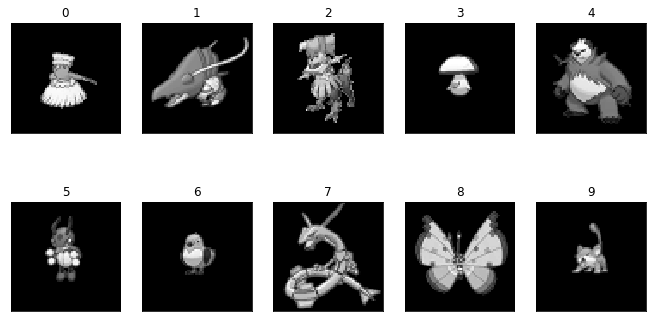

Epoch 41: Train_loss 0.000000
Epoch 42: Train_loss 0.000000
Epoch 43: Train_loss 0.000000
Epoch 44: Train_loss 0.000000
Epoch 45: Train_loss 0.000000
Epoch 46: Train_loss 0.000000
Epoch 47: Train_loss 0.000000
Epoch 48: Train_loss 0.000000
Epoch 49: Train_loss 0.000000
Epoch 50: Train_loss 0.000000


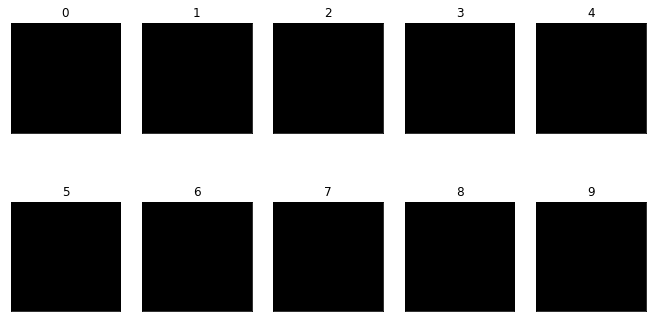

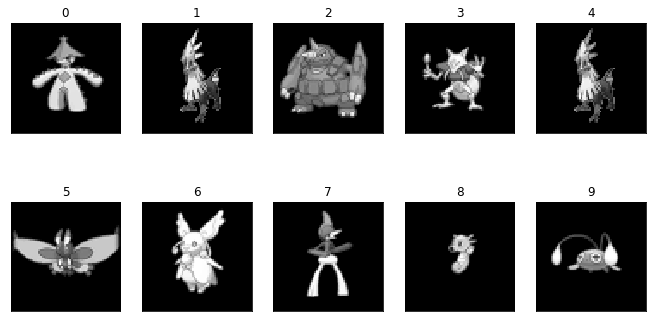

In [21]:
if not implemented:
    
    print('you need to complete the implementation')

else:

    training_epoch = 50

    # We have set a mini-batch set size of 30, having found that it works well in practice. Try setting it equal
    # to the size of the traning set and see how well it performs. You may have to change learning rate in this case.
    batch_size = 30
    # batch_size = len(images)

    for i in range(training_epoch):
        # We want to randomise the batches that we get for each epoch
        # Also helps for when the batch size does not divide nicely into the size of the dataset
        random_idxes = np.random.permutation(len(images))
        batches = [images[random_idxes[i*batch_size:(i+1)*batch_size]] for i in range(len(images)//batch_size)]

        loss_vals = []
        for (j, batch) in enumerate(batches):
            """
            This is the main training loop.
            You need to first run a forward pass on the encoder, get a code, then run the decoder on the code to get X_hat.
            Put these into the loss function, calculate the loss and do a back pass.
            Then update the network.
            Append the loss into the list loss_vals so we can see the average loss of each epoch.
            If you have used our hyperparamters, the learning rate we set should work for both the encoder and decoder.
            If you have changed the structure, experiment to see if you can find a good learning rante
            """
            learning_rate = 5e-3
            X = batch


            ###############
            #YOU CODE HERE#
            ###############

            X_hat = X * 0 # you code here

            train_loss = 0 # you code here
            loss_vals.append(train_loss)


        print("Epoch %d: Train_loss %f" %(i+1, np.mean(loss_vals)))
        show_every = 10
        if i % show_every == show_every - 1:
            plot_gallery(X_hat, np.arange(batch_size), 64, 64, min(2, int(np.ceil(batch_size/6))), 5)
            plot_gallery(X, np.arange(batch_size), 64, 64, min(2, int(np.ceil(batch_size/6))), 5)

Epoch 1: Train_loss 0.075456


Epoch 2: Train_loss 0.039121


Epoch 3: Train_loss 0.033144


Epoch 4: Train_loss 0.029052


Epoch 5: Train_loss 0.027365


Epoch 6: Train_loss 0.026600


Epoch 7: Train_loss 0.026414


Epoch 8: Train_loss 0.026235


Epoch 9: Train_loss 0.025764


Epoch 10: Train_loss 0.025927


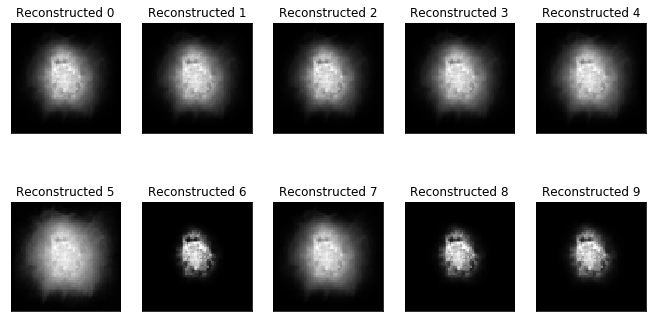

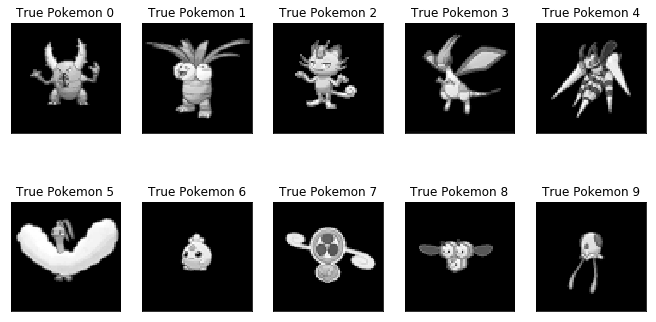

Epoch 11: Train_loss 0.025672


Epoch 12: Train_loss 0.025448


Epoch 13: Train_loss 0.025345


Epoch 14: Train_loss 0.024836


Epoch 15: Train_loss 0.024661


Epoch 16: Train_loss 0.024732


Epoch 17: Train_loss 0.024407


Epoch 18: Train_loss 0.024028


Epoch 19: Train_loss 0.024169


Epoch 20: Train_loss 0.023937


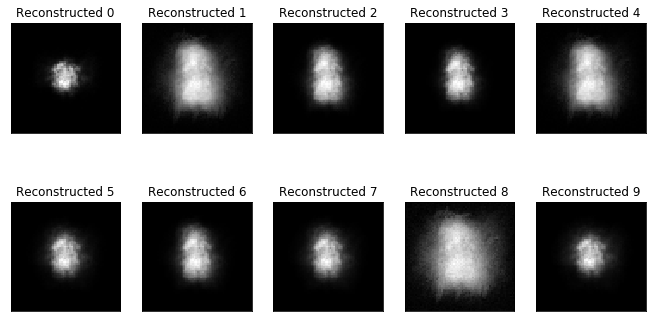

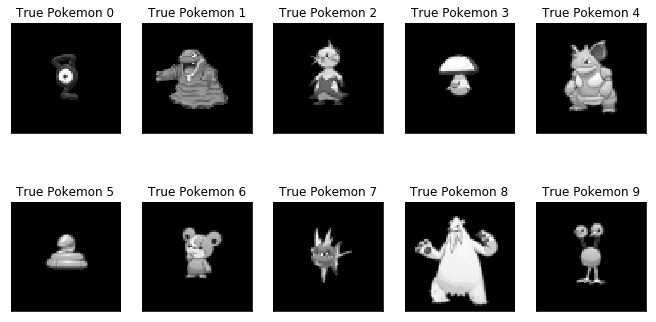

Epoch 21: Train_loss 0.023640


Epoch 22: Train_loss 0.023641


Epoch 23: Train_loss 0.023355


Epoch 24: Train_loss 0.022641


Epoch 25: Train_loss 0.022376


Epoch 26: Train_loss 0.022418


Epoch 27: Train_loss 0.021806


Epoch 28: Train_loss 0.021803


Epoch 29: Train_loss 0.021393


Epoch 30: Train_loss 0.021575


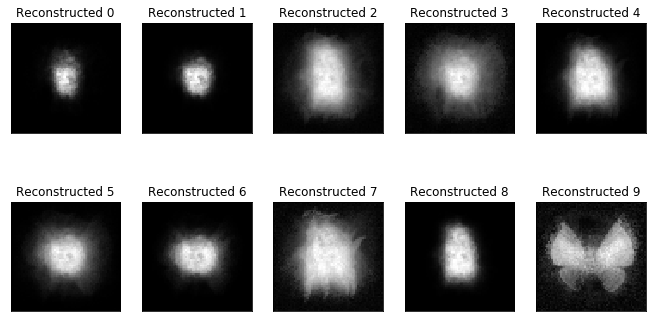

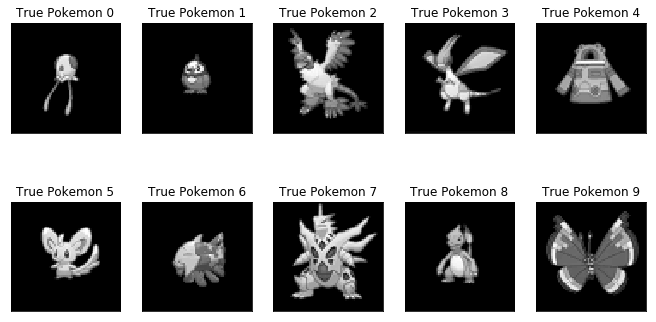

In [22]:
# Solution
training_epoch = 30

# We have set a mini-batch set size of 30, having found that it works well in practice. Try setting it equal
# to the size of the traning set and see how well it performs. You may have to change learning rate in this case.
batch_size = 30
# batch_size = len(images)

for i in range(training_epoch):
    # We want to randomise the batches that we get for each epoch
    # Also helps for when the batch size does not divide nicely into the size of the dataset
    random_idxes = np.random.permutation(len(images))
    batches = [images[random_idxes[i*batch_size:(i+1)*batch_size]] for i in range(len(images)//batch_size)]
    
    loss_vals = []
    for (j, batch) in enumerate(batches):
        """
        This is the main training loop.
        You need to first run a forward pass on the encoder, get a code, then run the decoder on the code to get X_hat.
        Put these into the loss function, calculate the loss and do a back pass.
        Then update the network.
        Append the loss into the list loss_vals so we can see the average loss of each epoch.
        If you have used our hyperparamters, the learning rate we set should work for both the encoder and decoder.
        If you have changed the structure, experiment to see if you can find a good learning rante
        """
        learning_rate = 5e-3
        X = batch
        
        code = encoder.forward_pass(X)
        X_hat = decoder.forward_pass(code)
        
        train_loss = mse.forward_pass(X_hat, X)
        loss_vals.append(train_loss)

        grad = mse.backward_pass()
        grad2 = decoder.backward_pass(grad)
        encoder.backward_pass(grad2)

        encoder.update(learning_rate)
        decoder.update(learning_rate)
        

    print("Epoch %d: Train_loss %f" %(i+1, np.mean(loss_vals)))
    show_every = 10
    if i % show_every == show_every - 1:
        plot_gallery(X_hat, ['Reconstructed {:d}'.format(i) for i in range(batch_size)], 64, 64, min(2, int(np.ceil(batch_size/6))), 5)
        plot_gallery(X, ['True Pokemon {:d}'.format(i) for i in range(batch_size)], 64, 64, min(2, int(np.ceil(batch_size/6))), 5)

## Visualising the autoencoder results
Visualise the autoencoder reconstructions for 30 images. Where they what you expect? Compare them to the reconstruction of 15 components. If you have time/are interested, try training for longer and/or the autoencoder with a higher bottleneck dimension.

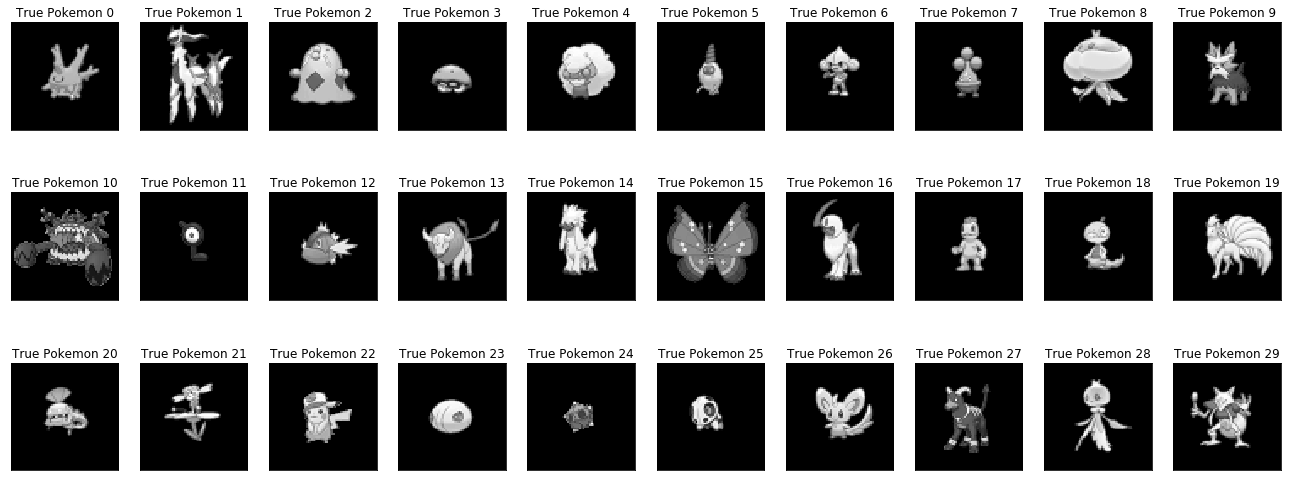

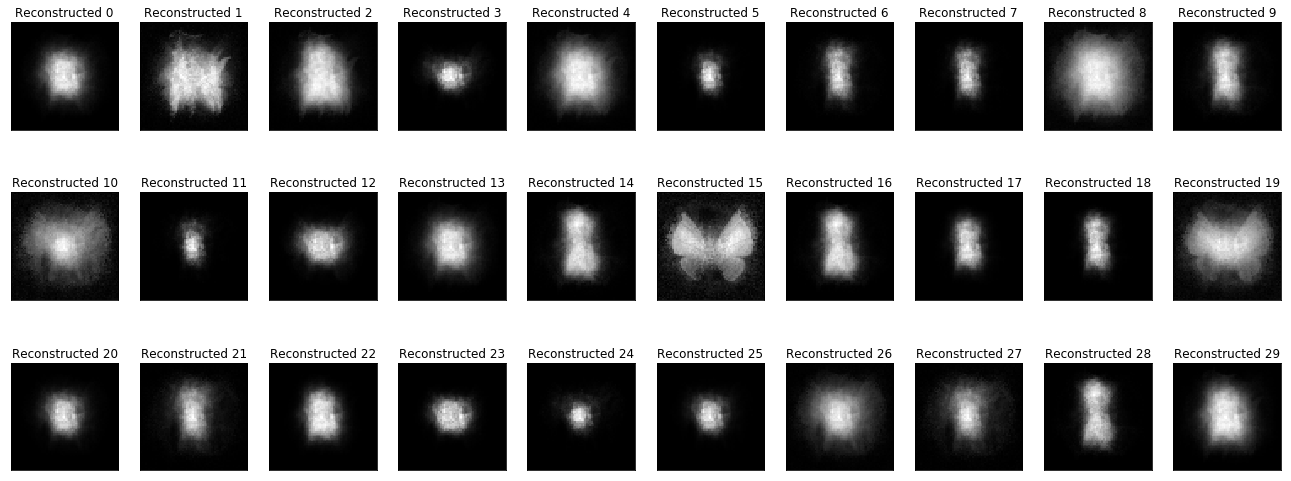

In [23]:
# Solution
num_images = 30
random_images = images[np.random.permutation(len(images))[:num_images]]
plot_gallery(random_images, ['True Pokemon {:d}'.format(i) for i in range(num_images)], h, w, num_images//10, 10)

code = encoder.forward_pass(random_images[:num_images])
recon = decoder.forward_pass(code)

plot_gallery(recon, ['Reconstructed {:d}'.format(i) for i in range(num_images)], h, w, num_images//10, 10)

## Visualising autoencoder features

You can find the features the autoencoder is picking up by decoding a hidden unit vector of the form $(0,\dots,0,1,0,\dots,0)$. How do these features compare to those detected by PCA? Also try visualising scaled versions of the features.

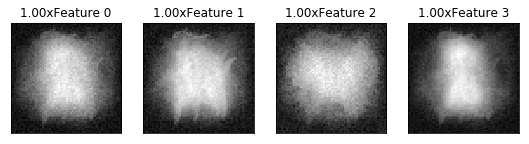

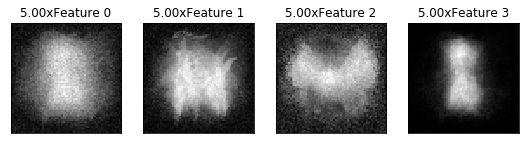

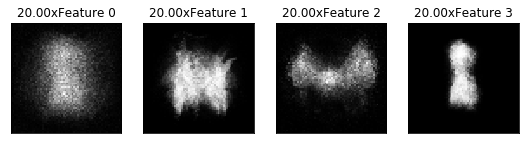

In [24]:
# Solution
for factor in [1, 5, 20]:
    code = factor*np.eye(4)
    recon = decoder.forward_pass(code)

    plot_gallery(recon, ['{:0.2f}xFeature {:d}'.format(factor, i) for i in range(4)], h, w, 1, 4)

## Autoencoder with linear transition functions

Training an autoencoder with linear transition functions should result in projecting the dataset to the same subspace as in PCA. Check this for 4 principal component.

Do do this, make a new encoder and decoder with bottleneck of dimension 4, and use no activations functions (so you only need to use 1 FullyConnectedLayer per network). Train the network again, and again look at what the basis vectors for the bottleneck dimension return (i.e. repeat the "Visualising autoencoder features" question with this new model).

In [25]:
# Solution
class Encoder(Network):
    def __init__(self):
        Network.__init__(self)
        
        fc1 = FullyConnectedLayer(4096, 4)
        fc1.init_weights()
        self.sequential.append(fc1)


class Decoder(Network):
    def __init__(self):
        Network.__init__(self)
        
        fc1 = FullyConnectedLayer(4, 4096)
        fc1.init_weights()
        self.sequential.append(fc1)

np.random.seed(1)
encoder = Encoder()
decoder = Decoder()
mse = MSELoss()

Epoch 1: Train_loss 0.029444
Epoch 2: Train_loss 0.024972
Epoch 3: Train_loss 0.023202
Epoch 4: Train_loss 0.021936


Epoch 5: Train_loss 0.021018
Epoch 6: Train_loss 0.020245
Epoch 7: Train_loss 0.019657
Epoch 8: Train_loss 0.019270


Epoch 9: Train_loss 0.019042
Epoch 10: Train_loss 0.019034


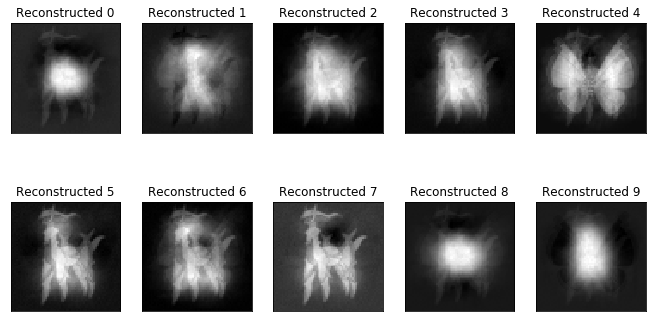

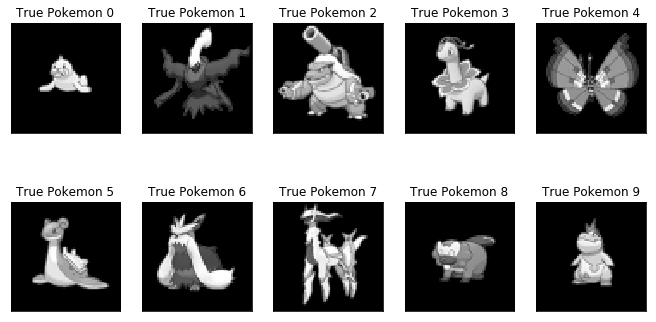

Epoch 11: Train_loss 0.019035
Epoch 12: Train_loss 0.019028
Epoch 13: Train_loss 0.018916
Epoch 14: Train_loss 0.018860


Epoch 15: Train_loss 0.019023
Epoch 16: Train_loss 0.019027
Epoch 17: Train_loss 0.018984
Epoch 18: Train_loss 0.019027


Epoch 19: Train_loss 0.019036
Epoch 20: Train_loss 0.018987


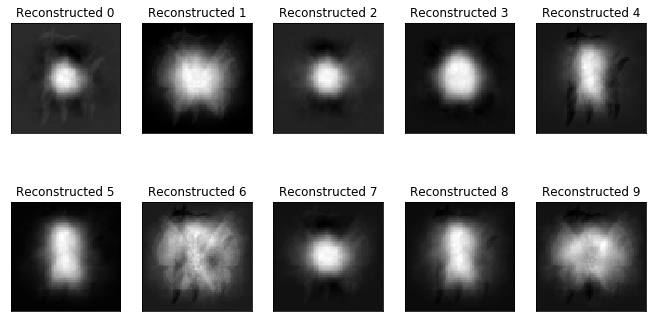

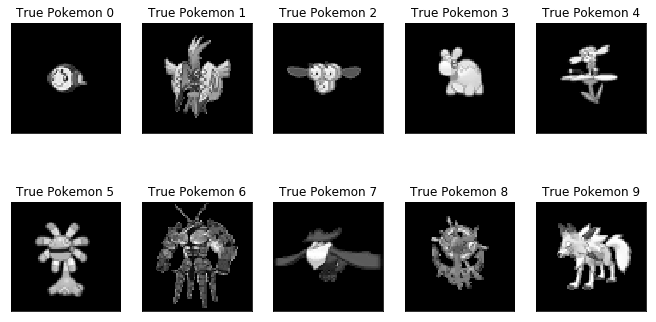

Epoch 21: Train_loss 0.019005
Epoch 22: Train_loss 0.018958
Epoch 23: Train_loss 0.019015
Epoch 24: Train_loss 0.018997


Epoch 25: Train_loss 0.019028
Epoch 26: Train_loss 0.018966
Epoch 27: Train_loss 0.018958
Epoch 28: Train_loss 0.018885


Epoch 29: Train_loss 0.019040
Epoch 30: Train_loss 0.019010


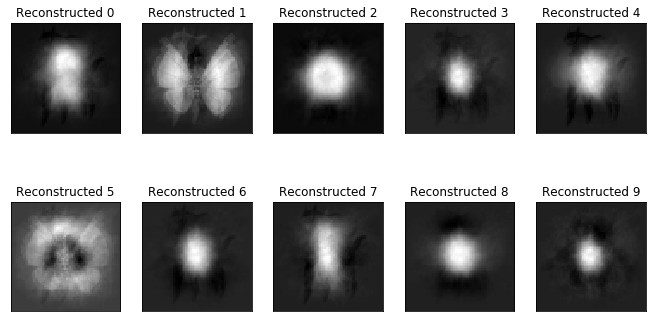

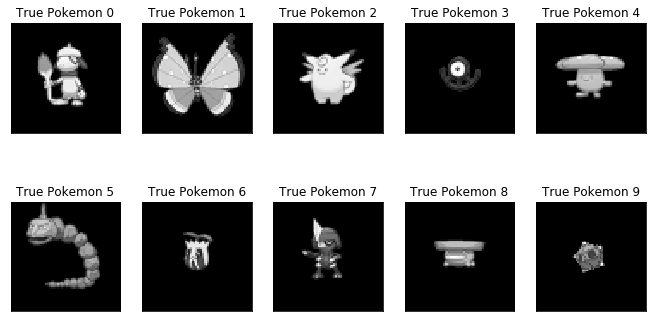

In [26]:
# Solution

training_epoch = 30

# We have set a mini-batch set size of 30, having found that it works well in practice. Try setting it equal
# to the size of the traning set and see how well it performs. You may have to change learning rate in this case.
batch_size = 30
# batch_size = len(images)

# We need to normalise to compare to PCA
M = np.mean(images, axis=0)

for i in range(training_epoch):
    # We want to randomise the batches that we get for each epoch
    # Also helps for when the batch size does not divide nicely into the size of the dataset
    random_idxes = np.random.permutation(len(images))
    batches = [images[random_idxes[i*batch_size:(i+1)*batch_size]] for i in range(len(images)//batch_size)]
    
    loss_vals = []
    for (j, batch) in enumerate(batches):
        """
        This is the main training loop.
        You need to first run a forward pass on the encoder, get a code, then run the decoder on the code to get X_hat.
        Put these into the loss function, calculate the loss and do a back pass.
        Then update the network.
        Append the loss into the list loss_vals so we can see the average loss of each epoch.
        If you have used our hyperparamters, the learning rate we set should work for both the encoder and decoder.
        If you have changed the structure, experiment to see if you can find a good learning rante
        """
        learning_rate = 5e-3
        X = batch
        
        X -= M
        
        code = encoder.forward_pass(X)
        X_hat = decoder.forward_pass(code)
        
        train_loss = mse.forward_pass(X_hat, X)
        loss_vals.append(train_loss)

        grad = mse.backward_pass()
        grad2 = decoder.backward_pass(grad)
        encoder.backward_pass(grad2)

        encoder.update(learning_rate)
        decoder.update(learning_rate)
        

    print("Epoch %d: Train_loss %f" %(i+1, np.mean(loss_vals)))
    show_every = 10
    if i % show_every == show_every - 1:
        plot_gallery(X_hat+M, ['Reconstructed {:d}'.format(i) for i in range(batch_size)], 64, 64, min(2, int(np.ceil(batch_size/6))), 5)
        plot_gallery(X+M, ['True Pokemon {:d}'.format(i) for i in range(100)], 64, 64, min(2, int(np.ceil(batch_size/6))), 5)

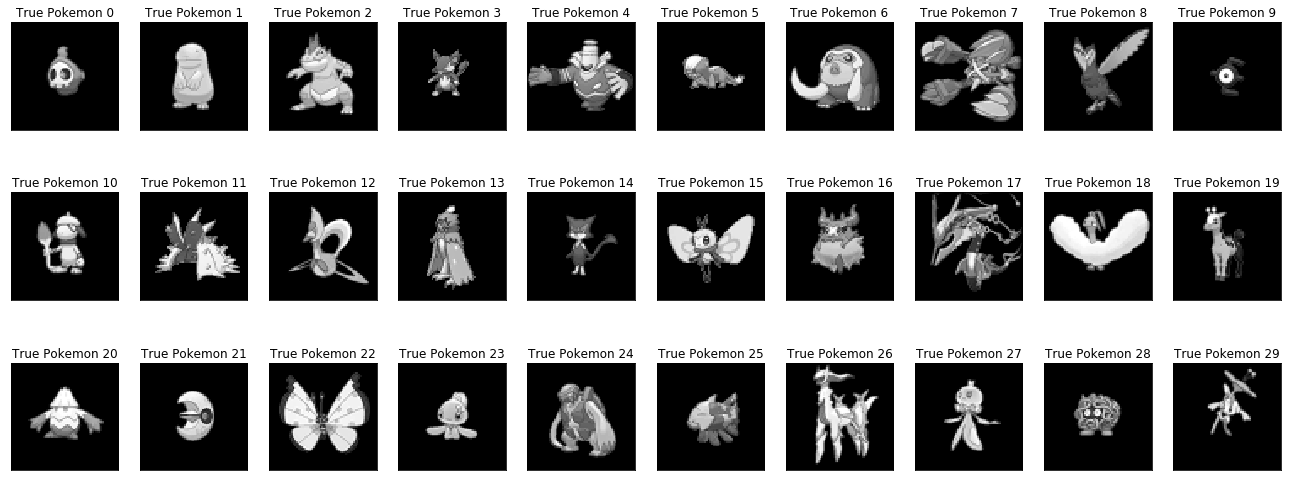

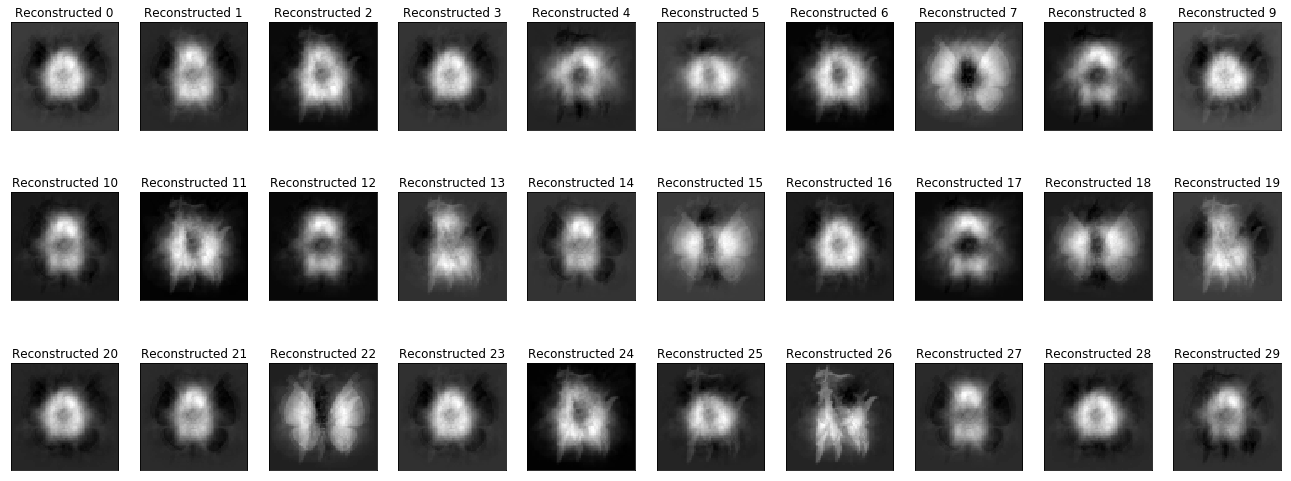

In [27]:
# Solution
num_images = 30
random_images = images[np.random.permutation(len(images))[:num_images]]
plot_gallery(random_images, ['True Pokemon {:d}'.format(i) for i in range(num_images)], h, w, num_images//10, 10)

code = encoder.forward_pass(random_images[:num_images])
recon = decoder.forward_pass(code)

plot_gallery(recon, ['Reconstructed {:d}'.format(i) for i in range(num_images)], h, w, num_images//10, 10)

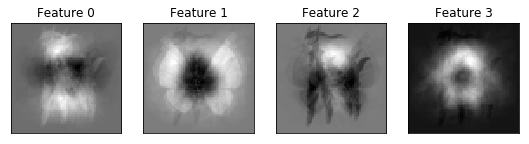

In [28]:
# Solution
code = np.eye(4)
recon = decoder.forward_pass(code)

plot_gallery(recon, ['Feature {:d}'.format(i) for i in range(4)], h, w, 1, 4)

### Solution:
The 4 features are very similar to the top 4 principle components learned by PCA, but are not in order. In fact, the autoencoder should learn 4 features that span the same 4 dimensional subspace as the top 4 principle components of PCA, but are unlikely to be normalised or orthogonal.